0.00930280576699
0.0368999546674
0.212193383911
0.574167791049
1.01483387988


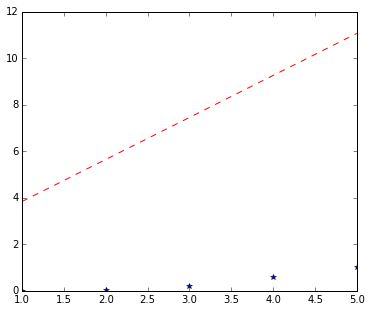

In [268]:
#####set up the environment
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import scipy.stats as stats
from scipy.stats import chi2
from lxml.html import parse
from urllib2 import urlopen
from os.path import getsize
from math import log
from pandas import Series, DataFrame
import urllib 
import statsmodels.api as sm
from statsmodels.tsa.stattools import q_stat, acf, pacf
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from datetime import datetime
%matplotlib inline

In [ ]:
def autocoef(data,k):
    meanw=np.mean(data)
    n=len(data)    
    return np.nansum((data[:(n-k)]-meanw)*(data[k:]-meanw))/np.nansum((data-meanw)**2)
def qtest(data,m,plot):
    q=np.zeros(m)
    l=[(autocoef(data,i+1))**2 for i in range(m)]
    for j in range(m):
        q[j]=sum(l[:j+1])*len(data)
        print(q[j])
    if plot==1:
        plt.figure(figsize=(6,5))
        plt.plot(range(1,m+1),q[:],"b*",[1,m],stats.chi2.ppf(0.95,[1,m]),"r--")
n=1000
data=np.random.normal(size=n)
qtest(data,5,1)

 + (a)
推导过程 
$${r_t} = {\phi _0} + {\phi _1}{r_{t - 1}} + {\phi _2}{r_{t - 2}} + {a_t}$$
对上式两边求期望得： 
$$E\left( {{r_t}} \right) = \frac{{{\phi _0}}}{{1 - {\phi _1} - {\phi _2}}}$$
下不妨设$\phi _0$为0，即考虑零均值的二阶自回归模型 $${r_t} ={\phi _1}{r_{t - 1}} + {\phi _2}{r_{t - 2}} + {a_t}$$
显然$${\rho _0} = 1$$
在${r_t} ={\phi _1}{r_{t - 1}} + {\phi _2}{r_{t - 2}} + {a_t}$两边同时乘上${r_{t - 1}}$得：
$${r_t}{r_{t - 1}} ={\phi _1}{r_{t - 1}}{r_{t - 1}} + {\phi _2}{r_{t - 2}}{r_{t - 1}} + {a_t}{r_{t - 1}}$$
对上式两边同时求期望得${\rho _1}={\phi _1}+{\phi _2}{\rho _1}$
即：$${\rho _1} = \frac{{{\phi _1}}}{{1 - {\phi _2}}}$$
再对原式两边同时乘上${r_{t - l}}$得：
$${r_t}{r_{t - l}} ={\phi _1}{r_{t - 1}}{r_{t - l}} + {\phi _2}{r_{t - 2}}{r_{t - l}} + {a_t}{r_{t - l}}$$
对上式两边同时求期望得$${\rho _l} = {\phi _1}{\rho _{l - 1}} + {\phi _2}{\rho _{l - 2}},\;\;\;{\kern 1pt} l \ge 1$$

故证毕

+ (b）
判断AR(2)是否是平稳函数

In [269]:
def pingwen(phi1,phi2):
    if (phi1**2+4*phi2)>0:
        a=np.abs((-phi1+np.sqrt(phi1**2+4*phi2))/(2*phi2))
        b=np.abs((-phi1-np.sqrt(phi1**2+4*phi2))/(2*phi2))
        if a>1 and b>1:
            print('满足平稳条件')
        else:
            print('不满足平稳条件')
    else:
        if -1/phi2>1:
             print('满足平稳条件')
        else:
            print('不满足平稳条件')

In [270]:
pingwen(0.7,-0.3)

满足平稳条件


计算自相关系数

In [271]:
def xiangguan(phi1,phi2,p):
    y=1;z=phi1/(1-phi2)
    x=[y,z]
    for i in range(2,p+1):
        t=phi1*z+phi2*y
        x.append(t)
        y=z;z=t
    return x

In [272]:
xiangguan(0.7,-0.3,20)

[1,
 0.5384615384615384,
 0.07692307692307687,
 -0.10769230769230771,
 -0.09846153846153846,
 -0.036615384615384605,
 0.003907692307692317,
 0.013720000000000003,
 0.008431692307692307,
 0.0017861846153846136,
 -0.0012791784615384626,
 -0.0014312803076923079,
 -0.0006181426769230767,
 -3.3157815384613257e-06,
 0.00018312175600000008,
 0.00012917996366153844,
 3.548944776307688e-05,
 -1.3911375664307719e-05,
 -2.0384797293938465e-05,
 -1.0095945406464609e-05,
 -9.51722596343687e-07]

In [273]:
#借用部分小组作业时的代码
from lxml.html import parse
from urllib2 import urlopen
from os.path import getsize
import pandas as pd
import urllib 
from __future__ import division
import os
import sys
import matplotlib  
from matplotlib.pyplot import plot,savefig 

import numpy as np
from numpy.random import randn
from pandas import Series, DataFrame
import pandas as pd
import matplotlib.pyplot as plt


def get_sina_stock(stockid,start="1990-12-19",end=pd.datetime.now(),isstock=True,fuquan=True):    
    def _unpack(row, kind='td'):
        elts = row.findall('.//%s' % kind)
        return [val.text_content().strip() for val in elts] 
    def parse_options_data(table,isstock,fuquan):
        rows = table.findall('.//tr')
        data = [_unpack(r) for r in rows[2:]]
        if isstock & fuquan:
            colnames = ['date','open','high','close','low','vol','amount','ratio'] 
        else:
            colnames = ['date','open','high','close','low','vol','amount']
        data= pd.DataFrame(data,columns=colnames)
        data.index=pd.to_datetime(data["date"])
        data=data.drop("date",axis=1)
        data=data.ix[range(len(data)-1,-1,-1)]
        return  data
    data=pd.DataFrame()
    daterange=pd.date_range(start,end,freq="Q")
    daterange=daterange.insert(len(daterange),daterange[-1]+1)
    for cq in daterange: 
        if isstock:
            if fuquan:
                url='http://vip.stock.finance.sina.com.cn/corp/go.php/vMS_FuQuanMarketHistory/stockid/'+str(stockid)+'.phtml?year='+str(cq.year)+'&jidu='+str(cq.month/3)
            else:
                url='http://vip.stock.finance.sina.com.cn/corp/go.php/vMS_MarketHistory/stockid/'+str(stockid)+'.phtml?year='+str(cq.year)+'&jidu='+str(cq.month/3)            
        else:            
            url='http://vip.stock.finance.sina.com.cn/corp/go.php/vMS_MarketHistory/stockid/'+str(stockid)+'/type/S.phtml?year='+str(cq.year)+'&jidu='+str(cq.month/3)
        try:
            parsed = parse(urlopen(url))
        except:
            print "download failed for year=" +str(cq.year)+',  jidu='+str(cq.month/3)
            continue
        doc = parsed.getroot()
        tables=doc.findall('.//table')     
        da= tables[-1] # last table 19 for fuquan data and 4 for index
        datatem = parse_options_data(da,isstock,fuquan)
        data=pd.concat([data,datatem])
    return pd.DataFrame(data[start:end],dtype=float)

0.427123156762
19.962223873
20.018595011
33.6341124294
34.214602087


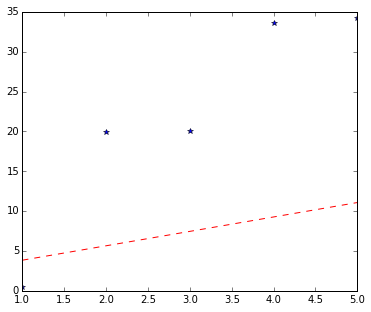

In [274]:
data=get_sina_stock(600426,"2013-1-1","2015-12-1")
SimpleReturnDaily1=data["close"].pct_change()
SimpleReturnDaily1=SimpleReturnDaily1.dropna()
SimpleReturnDaily1=list(SimpleReturnDaily1)
qtest(SimpleReturnDaily1,5,1)

由图可见不满足平稳条件，下面用AR模型来拟合

In [275]:
from scipy.linalg import toeplitz
#95%的阀值为：
print(1.96/np.sqrt(len(SimpleReturnDaily1)))

def mypacf(ac,k):    
    r=ac[:k]
    R = toeplitz(r[:-1])
    rho = np.linalg.solve(R, r[1:])
    return(rho)

print(mypacf(SimpleReturnDaily1,10))
print(mypacf(SimpleReturnDaily1,11))
print(mypacf(SimpleReturnDaily1,12))

0.0742402938697
[ 0.29857645  0.29030227  0.76853399  0.72617834  1.68250476  1.14581211
  1.01824447  0.82767706 -0.72099085]
[ 0.79672168 -0.28155434  0.06501101 -0.06548336  0.52003269  0.64408275
  0.48725085  0.62710212 -0.92728256  0.69091755]
[ 0.89328299 -0.41114956  0.1526536   0.00261388  0.61004845  0.71676152
  0.47809902  0.63618794 -0.96663205  0.80226584 -0.13975808]


阶数应该为11

In [276]:
# 最小二乘估计
import statsmodels.formula.api as sm
# 自回归的数据矩阵　lagmat
from statsmodels.tsa.tsatools import  lagmat
A=lagmat(SimpleReturnDaily1,11)
results = sm.OLS(SimpleReturnDaily1, A).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.080
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     5.437
Date:                Fri, 11 Dec 2015   Prob (F-statistic):           2.46e-08
Time:                        20:14:46   Log-Likelihood:                 1508.5
No. Observations:                 697   AIC:                            -2995.
Df Residuals:                     686   BIC:                            -2945.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             0.0268      0.038      0.702      0.4

上表中coef即为拟合的系数

In [1]:
A1 = pd.read_table("gdp.csv",sep=",")
SimpleReturnDaily=A1["gdp"].pct_change()
SimpleReturnDaily=SimpleReturnDaily.dropna()
SimpleReturnDaily=list(SimpleReturnDaily)
qtest(SimpleReturnDaily,5,1)

NameError: name 'pd' is not defined

由上图可知不是白噪声，下面用AR模型拟合

In [278]:
from statsmodels.tsa.stattools import pacf
pacf(SimpleReturnDaily,10)

array([ 1.        ,  0.62982892, -0.18053684,  0.02266526,  0.13172511,
        0.2406439 ,  0.1042829 ,  0.02685878, -0.1058745 ,  0.14390792,
        0.04443043])

可以看出阶数为2

In [279]:
# 最小二乘估计
import statsmodels.formula.api as sm
# 自回归的数据矩阵　lagmat
from statsmodels.tsa.tsatools import  lagmat
X=lagmat(SimpleReturnDaily,2)
results = sm.OLS(SimpleReturnDaily, X).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.688
Model:                            OLS   Adj. R-squared:                  0.678
Method:                 Least Squares   F-statistic:                     66.28
Date:                Fri, 11 Dec 2015   Prob (F-statistic):           6.41e-16
Time:                        20:14:46   Log-Likelihood:                 71.495
No. Observations:                  62   AIC:                            -139.0
Df Residuals:                      60   BIC:                            -134.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             0.8269      0.129      6.405      0.0

In [280]:
print(u'方差：'+str(results.resid.std()))
print(u'期望：'+str(results.resid.mean()))

方差：0.0740957701148
期望：0.018521792595


In [281]:
phi1=0.8269;phi2=0.006
2*np.pi/np.arccos(phi1/(2*np.sqrt(-phi2)))

nan

无周期

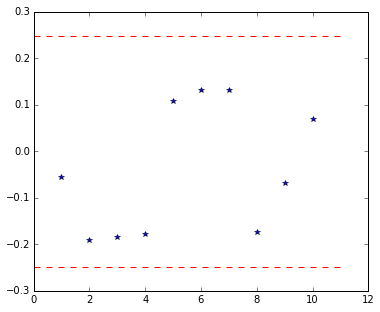

In [282]:
k=10
autoco=[autocoef(results.resid,i) for i in range(k+1)]
n=len(results.resid)
plt.figure(figsize=(6,5))
plt.plot(range(1,k+1),autoco[1:],"b*",[0,k+1],[1.96/np.sqrt(n)]*2,"r--",[0,k+1],[-1.96/np.sqrt(n)]*2,"r--")

由上图知，拟合模型的残差符合白噪声模型

In [283]:
n=len(SimpleReturnDaily)
x1=SimpleReturnDaily[n-2]
x2=SimpleReturnDaily[n-1]

In [291]:
sig=results.resid.std()
a=results.predict(exog=[x1,x2])
print('2015年预测值：'+str(a))
print('%95的置信区间：'+str(a-1.96*sig)+'-'+str(a+1.96*sig))

2015年预测值：[ 0.07941253]
%95的置信区间：[-0.06581518]-[ 0.22464024]


In [292]:
b=results.predict(exog=[x2,a])
print('2016年预测值：'+str(b))
print('%95的置信区间：'+str(b-1.96*sig)+'-'+str(b+1.96*sig))

2016年预测值：[ 0.06363451]
%95的置信区间：[-0.0815932]-[ 0.20886222]
